## Solving dynamic finite-horizon optimisation problems recursively

In [3]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

The basic problem structure is as follows:
$$\underset{{K_{t+1}, I_t}}{max} \sum^T_{t=0}\beta^t h(K_t, I_t)$$
$$s.t. \: K_{t+1} = f(K_t,I_t) \: \forall t$$
This can be thought of as representing the problem of optimal investment in capabilities to maximise present discounted value of happiness across the lifespan

The objective is to find functions $h, f$ such that the optimal happiness trajectory $h(\tilde{K}_{t+1}, \tilde{I}_t)$ is U-shaped

Start by defining a function that solves the finite-horizon optimisation problem numerically via backward induction, and then simulates the solution trajectory from a specified starting point 

In [8]:
def solve_and_simulate(K0, Tsim, gamma_path, delta_path, A, alpha, beta, h_of_t, K_grid, I_grid, K_next):

    #### DO BACKWARD INDUCTION TO SOLVE THE TIME-DEPENDENT PROBLEM

    # V[t, iK] holds value at time t for K_grid[iK]; V[Tsim,:] is terminal value = 0
    V = np.zeros((Tsim + 1, nK))
    policy_I_idx = np.zeros((Tsim, nK), dtype=int)  # index of optimal I for each (t, K_index)

    # Backwards loop
    # note that we keep V[Tsim, :] = 0 as the terminal condition: this is the transversality condition (TVC)
    for t in range(Tsim - 1, -1, -1):  # t = Tsim-1, ..., 0
        # create interpolator for V[t+1, .]
        Vnext_interp = interp1d(K_grid, V[t + 1], kind='linear', fill_value='extrapolate', assume_sorted=True)
        delta_t = delta_path[t]
        # loop across K grid
        for iK, K in enumerate(K_grid):

            # compute feasible K' for each candidate I (vector)
            Knext = K_next(K, I_grid, delta_t)

            # clip onto interpolation domain (alternatively expand K_grid to avoid clipping)
            Knext_clipped = np.clip(Knext, Kmin, Kmax)

            # calculate continuation value for each candidate I
            cont_val = Vnext_interp(Knext_clipped)        # V[t+1](K') vector of length nI

            # immediate payoff vector for all candidate I (length nI)
            h_vec = h_of_t(K, I_grid, t)
            total = h_vec + beta * cont_val               # total value for each I
            jstar = int(np.argmax(total))                 # index of best I
            V[t, iK] = total[jstar]
            policy_I_idx[t, iK] = jstar

        # Optionally print progress
        if (t % 10) == 0:
            print(f'Backward step done: t={t}')

    print('Backward induction finished.')

    # -------------------------
    # Build time-dependent policy function objects for simulation
    # -------------------------
    policy_I_vals = I_grid[policy_I_idx]   # shape (Tsim, nK)
    # note this is equivalent to policy_I_vals[t, iK] = I_grid[policy_I_idx[t, iK]]

    # build interpolator for each time period (so we can evaluate I*_t(K) at off-grid K)
    policy_fun = [
        interp1d(K_grid, policy_I_vals[t], kind='linear',
                fill_value=(Imin, Imax), bounds_error=False, assume_sorted=True)
        for t in range(Tsim)
    ]


    #### NOW SIMULATE

    Ks = np.empty(Tsim + 1)
    Is = np.empty(Tsim)
    hs = np.empty(Tsim)
    Ks[0] = K0

    for t in range(Tsim):
        # evaluate policy at current K_t using the t-th policy function
        I_t = float(policy_fun[t](Ks[t]))
        Is[t] = I_t
        hs[t] = (A * (Ks[t]**alpha) - gamma_path[t] * (I_t**2))   # h_t = h(K_t,I_t,t)
        # update K
        Ks[t + 1] = (1.0 - delta_path[t]) * Ks[t] + I_t


    #### NOW PLOT RESULTS

    plt.figure(figsize=(8,4))
    plt.plot(np.arange(Tsim+1), Ks, marker='o', markersize=3)
    plt.title('K_t (capital)')
    plt.xlabel('time t')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(np.arange(Tsim), Is, marker='o', markersize=3)
    plt.title('I_t (investment policy)')
    plt.xlabel('time t')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(np.arange(Tsim), hs, marker='o', markersize=3)
    plt.title('h_t = h(K_t,I_t) (period payoff)')
    plt.xlabel('time t')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Set up the grids to do the numerical optimisation over

In [10]:
# set the state and control grids
Kmin, Kmax, nK = 0.1, 10.0, 300
K_grid = np.linspace(Kmin, Kmax, nK)
Imin, Imax, nI = 0.0, 2.5, 201
I_grid = np.linspace(Imin, Imax, nI)

Now solve the model with some baseline values: first the most basic, with no explicit time-dependence

In [18]:
# do the parameters and the code here

Backward step done: t=70
Backward step done: t=60
Backward step done: t=50
Backward step done: t=40
Backward step done: t=30
Backward step done: t=20
Backward step done: t=10
Backward step done: t=0
Backward induction finished.


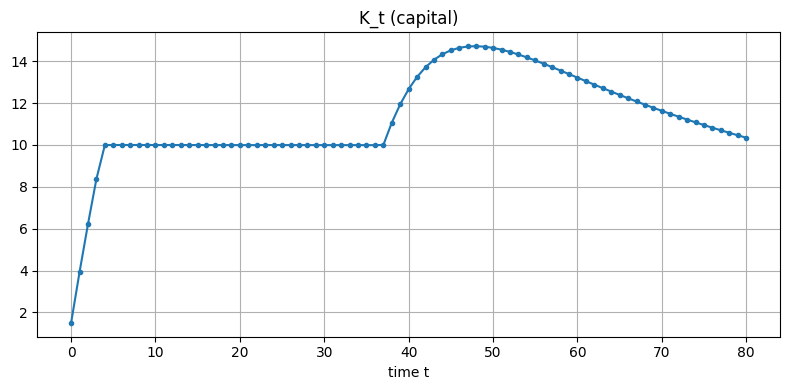

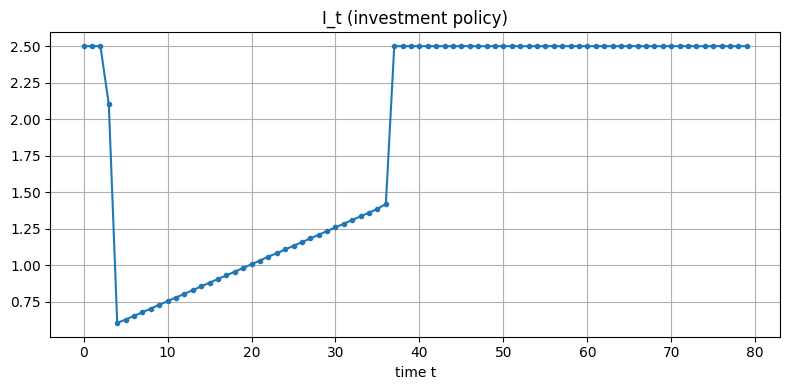

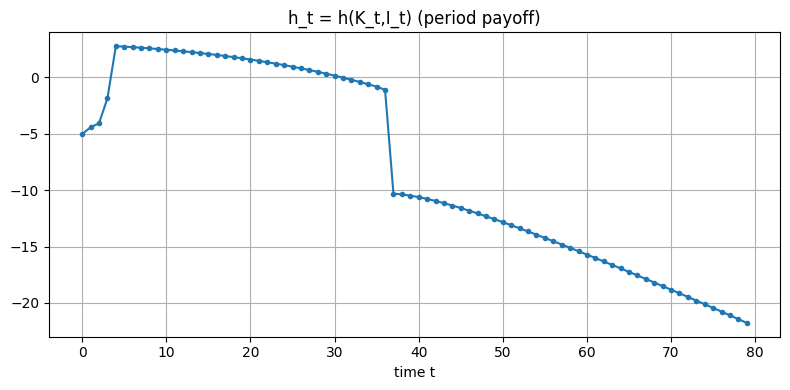

In [17]:
# set parameter values
A = 1.0
alpha = 0.5
beta = 0.95
Tsim = 80  # number of decision periods (0..Tsim-1). V[Tsim] is terminal value (set to 0, by the transversality condition under the condition we need capital stock positive at final period).
gamma_path = np.linspace(1, 2, Tsim)**2  # increasing investment cost over time
delta_path = np.linspace(0.05, 0.25, Tsim)  # increasing depreciation over time
K0 = 1.5  # choose initial capital within [Kmin, Kmax]

# precalculate payoff function depending on time t, h(K,I,t), vectorised in I
def h_of_t(K, I_grid, t):
    gamma_t = gamma_path[t]
    return A * (K**alpha) - (I_grid/gamma_t)

# define the law of motion function, dependent on time t
def K_next(K, I_grid, delta_t):
    return (1.0 - delta_t) * K + I_grid

solve_and_simulate(K0, Tsim, gamma_path, delta_path, A, alpha, beta, h_of_t, K_grid, I_grid, K_next)
